# Replication study: Anyone for Tennis (Betting)? von Forrest,D und McHale,I 2007

## Part 2: The Model

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
import seaborn as sns
sns.set(style="whitegrid")
from collections import defaultdict
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Load dataset from part 1
Original=pd.read_csv("Original.csv")
Replication=pd.read_csv("Replication.csv")

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17,18,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
Replication.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44985 entries, 0 to 45030
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             44985 non-null  object 
 1   Location         44985 non-null  object 
 2   Winner           44985 non-null  object 
 3   Loser            44985 non-null  object 
 4   B365W            44985 non-null  float64
 5   B365L            44985 non-null  float64
 6   WRank            44968 non-null  float64
 7   LRank            44902 non-null  float64
 8   Series           44985 non-null  object 
 9   Round            44985 non-null  object 
 10  book_implied_pW  44985 non-null  float64
 11  book_implied_pL  44985 non-null  float64
 12  implied_pW       44985 non-null  object 
 13  implied_pL       44985 non-null  object 
 14  implied_pFav     44985 non-null  object 
 15  implied_pOut     44985 non-null  object 
 16  Choice           44985 non-null  int32  
 17  bet_p       

### Data preparations for the model

In [4]:
# Keep only important columns
Original= Original.loc[:,['Date',"Location", 'Winner', 'Loser', 'B365W', 'B365L',"WRank","LRank","Series","Round"]]
Replication= Replication.loc[:,['Date',"Location", 'Winner', 'Loser', 'B365W', 'B365L',"WRank","LRank","Series","Round"]]

In [5]:
# Take the inverse of the odds = implied probobality
Original["book_implied_pW"] = 1/Original.B365W
Original["book_implied_pL"] = 1/Original.B365L

Replication["book_implied_pW"] = 1/Replication.B365W
Replication["book_implied_pL"] = 1/Replication.B365L

In [6]:
# New columns where the player is paired with his odds
Original["implied_pW"] = [[x, y]
                           for x, y in zip(Original.Winner, Original.book_implied_pW)]
Original["implied_pL"] = [[x, y]
                           for x, y in zip(Original.Loser, Original.book_implied_pL)]

Replication["implied_pW"] = [[x, y]
                           for x, y in zip(Replication.Winner, Replication.book_implied_pW)]
Replication["implied_pL"] = [[x, y]
                           for x, y in zip(Replication.Loser, Replication.book_implied_pL)]

In [7]:
# create new column to seperate favorites und outsiders
implied_pFav = [] # implied probobality favorite
implied_pOut = [] # implied probobality outsider

for i in range(Original.shape[0]):
    if Original["implied_pW"].iloc[i][1] >= Original["implied_pL"].iloc[i][1]: # filters all favorites that won
        implied_pFav.append(Original["implied_pW"].iloc[i])
    else:
        implied_pFav.append(Original["implied_pL"].iloc[i]) # filters all favorites that lost

for i in range(Original.shape[0]):
    if Original["implied_pW"].iloc[i][1] < Original["implied_pL"].iloc[i][1]: # filters all outsiders that won
        implied_pOut.append(Original["implied_pW"].iloc[i])
    else:
        implied_pOut.append(Original["implied_pL"].iloc[i]) # filters all outsiders that lost

# add the list with favorites und outsiders to the table
Original["implied_pFav"] = implied_pFav
Original["implied_pOut"] = implied_pOut

implied_pFav = []
implied_pOut = []

for i in range(Replication.shape[0]):
    if Replication["implied_pW"].iloc[i][1] >= Replication["implied_pL"].iloc[i][1]:
        implied_pFav.append(Replication["implied_pW"].iloc[i])
    else:
        implied_pFav.append(Replication["implied_pL"].iloc[i])

for i in range(Replication.shape[0]):
    if Replication["implied_pW"].iloc[i][1] < Replication["implied_pL"].iloc[i][1]:
        implied_pOut.append(Replication["implied_pW"].iloc[i])
    else:
        implied_pOut.append(Replication["implied_pL"].iloc[i])


Replication["implied_pFav"] = implied_pFav
Replication["implied_pOut"] = implied_pOut

In [8]:
# Random selection of a match:
# Bet on favorite == 1
# Bet on outsider == 0

state = np.random.seed(0)

Choice = np.random.randint(2, size=Original.shape[0])
Original["Choice"] = Choice

Choice = np.random.randint(2, size=Replication.shape[0])
Replication["Choice"] = Choice

In [9]:
# new column: Odds for the random selected player
bet_p = []

for i in range(Original.shape[0]):
    if Original.Choice.iloc[i] == 1:
        bet_p.append(Original["implied_pFav"].iloc[i][1])
    else:
        bet_p.append(Original["implied_pOut"].iloc[i][1])

Original["bet_p"] = bet_p

bet_p = []

for i in range(Replication.shape[0]):
    if Replication.Choice.iloc[i] == 1:
        bet_p.append(Replication["implied_pFav"].iloc[i][1])
    else:
        bet_p.append(Replication["implied_pOut"].iloc[i][1])

Replication["bet_p"] = bet_p

In [10]:
# result of the bet:
# if win: result = odds - 1
# if lost: result = - 1
result = []

for i in range(Original.shape[0]):
    # select all bets on favorites which won
    if (Original.Choice.iloc[i] == 1) & (Original["implied_pFav"].iloc[i][0] == Original.Winner.iloc[i]):
        result.append(Original.B365W.iloc[i]-1)
    # select all bets on outsiders which won
    elif (Original.Choice.iloc[i] == 0) & (Original["implied_pOut"].iloc[i][0] == Original.Winner.iloc[i]):
        result.append(Original.B365W.iloc[i]-1)
    else:
        result.append(-1)  # All bets which lost

Original["result"] = result

result = []

for i in range(Replication.shape[0]):
    if (Replication.Choice.iloc[i] == 1) & (Replication["implied_pFav"].iloc[i][0] == Replication.Winner.iloc[i]):
        result.append(Replication.B365W.iloc[i]-1)
    elif (Replication.Choice.iloc[i] == 0) & (Replication["implied_pOut"].iloc[i][0] == Replication.Winner.iloc[i]):
        result.append(Replication.B365W.iloc[i]-1)
    else:
        result.append(-1)

Replication["result"] = result

### Linear model
Return =  $\alpha + \beta$ * implied probobality

In [11]:
# x1 independent variable and result/return dependent variable
x1 = Original["bet_p"]
y = Original["result"]

R_x1 = Replication["bet_p"]
R_y = Replication["result"]

In [12]:
X = sm.add_constant(x1)

ols_model = sm.OLS(y, X,)
results = ols_model.fit()
results.params

const   -0.282444
bet_p    0.352643
dtype: float64

In [13]:
R_X = sm.add_constant(R_x1)

ols_model = sm.OLS(R_y, R_X,)
results = ols_model.fit()
results.params

const   -0.257570
bet_p    0.304447
dtype: float64

### Logistic regression (Koning, 2012)

WinPercentage = $\frac{1}{1+exp(-\beta_0 - \beta_1 * log(fairOdds - 1))}$

In [14]:
# delte all rows where favorit has a 100% implied probobality
Original=Original[Original.bet_p!=1].copy()

Replication=Replication[Replication.bet_p!=1].copy()

In [21]:
# Transform into fair odds
fav_fair_p = []
out_fair_p = []

# Formula: odds for favorite divided by sum of favorites and outsider odds
for i in range(Original.shape[0]):
    fav_fair_p.append(Original["implied_pFav"].iloc[i][1]/(
        Original["implied_pFav"].iloc[i][1]+Original["implied_pOut"].iloc[i][1]))
    out_fair_p.append(Original["implied_pOut"].iloc[i][1]/(
        Original["implied_pFav"].iloc[i][1]+Original["implied_pOut"].iloc[i][1]))

Original["fav_fair_p"] = fav_fair_p
Original["out_fair_p"] = out_fair_p

fav_fair_p = []
out_fair_p = []

for i in range(Replication.shape[0]):
    fav_fair_p.append(Replication["implied_pFav"].iloc[i][1]/(
        Replication["implied_pFav"].iloc[i][1]+Replication["implied_pOut"].iloc[i][1]))
    out_fair_p.append(Replication["implied_pOut"].iloc[i][1]/(
        Replication["implied_pFav"].iloc[i][1]+Replication["implied_pOut"].iloc[i][1]))

Replication["fav_fair_p"] = fav_fair_p
Replication["out_fair_p"] = out_fair_p

In [22]:
# Find the fair odd for the selected bets 
Original["fair_bet_p"]=np.where(Original.Choice==1,Original["fav_fair_p"],Original["out_fair_p"])

Replication["fair_bet_p"]=np.where(Replication.Choice==1,Replication["fav_fair_p"],Replication["out_fair_p"])

In [25]:
# Win or lost of a bet: win == 1 and lost == 0 
Win = []

for i in range(Original.shape[0]):
    if (Original.Choice.iloc[i] == 1) & (Original["implied_pFav"].iloc[i][0] == Original.Winner.iloc[i]):
        Win.append(1)
    elif (Original.Choice.iloc[i] == 0) & (Original["implied_pOut"].iloc[i][0] == Original.Winner.iloc[i]):
        Win.append(1)
    else:
        Win.append(0)

Original["Win"] = Win

Win = []

for i in range(Replication.shape[0]):
    if (Replication.Choice.iloc[i] == 1) & (Replication["implied_pFav"].iloc[i][0] == Replication.Winner.iloc[i]):
        Win.append(1)
    elif (Replication.Choice.iloc[i] == 0) & (Replication["implied_pOut"].iloc[i][0] == Replication.Winner.iloc[i]):
        Win.append(1)
    else:
        Win.append(0)

Replication["Win"] = Win

In [32]:
x=np.log(1/Original["fair_bet_p"]-1)
y=Original["Win"]

R_x=np.log(1/Replication["fair_bet_p"]-1)
R_y=Replication["Win"]

In [30]:
X = sm.add_constant(x)
gam_bs = statsmodels.discrete.discrete_model.Logit(y,X)

res_bs = gam_bs.fit()

res_bs.summary()

Optimization terminated successfully.
         Current function value: 0.580524
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 8232
Model:                          Logit   Df Residuals:                     8230
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Sep 2020   Pseudo R-squ.:                  0.1624
Time:                        11:35:16   Log-Likelihood:                -4778.9
converged:                       True   LL-Null:                       -5705.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.025      0.703      0.482      -0.031       0.066
fair_bet_p    -1.2046      0.033    -36.955      0.000      -1.269      -1.141
==============================================================================
"""

In [33]:
R_X = sm.add_constant(R_x)
gam_bs = statsmodels.discrete.discrete_model.Logit(R_y,R_X)

res_bs = gam_bs.fit()

res_bs.summary()

Optimization terminated successfully.
         Current function value: 0.565272
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                44985
Model:                          Logit   Df Residuals:                    44983
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Sep 2020   Pseudo R-squ.:                  0.1845
Time:                        11:35:37   Log-Likelihood:                -25429.
converged:                       True   LL-Null:                       -31181.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.011      0.539      0.590      -0.015       0.027
fair_bet_p    -1.1239      0.013    -89.743      0.000      -1.148      -1.099
==============================================================================
"""

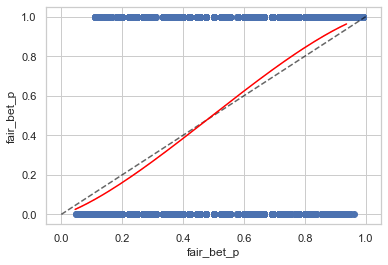

In [34]:
plt.scatter(Original.bet_p,Original.Win)
plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11),
         c="black", linestyle='dashed', alpha=0.6)
sns.lineplot(Original["fair_bet_p"],1/(1+np.exp(-0.0174+1.2046*x)),color="red")

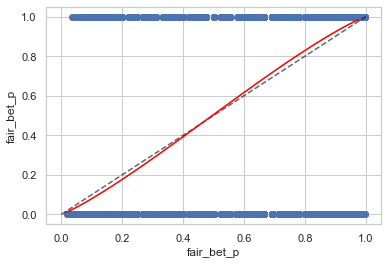

In [36]:
plt.scatter(Replication.bet_p,Replication.Win)
plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11),
         c="black", linestyle='dashed', alpha=0.6)
sns.lineplot(Replication["fair_bet_p"],1/(1+np.exp(-0.0191+1.124*R_x)),color="red")

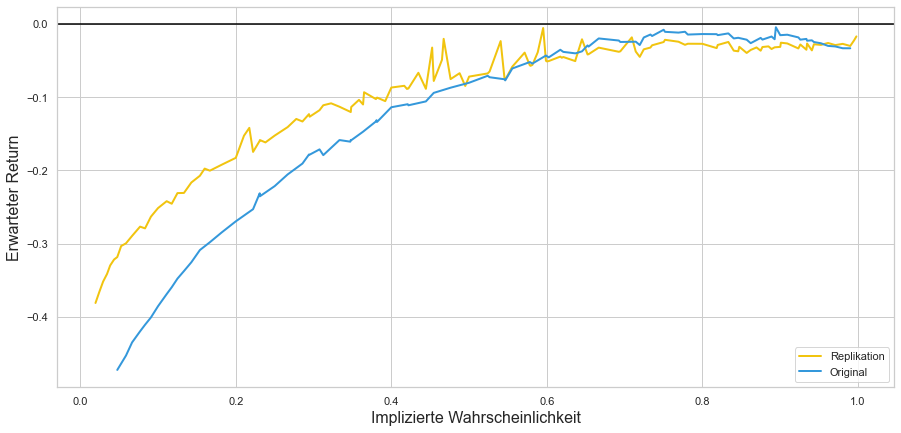

In [37]:
x=Replication["bet_p"]
x_reg=np.log(1/Replication["fair_bet_p"]-1)
y= (1/(1+np.exp(-0.0191+1.124*x_reg))/x)-1
odds = defaultdict(list)
for i,y in zip(x,y):
    odds[i].append(y)
xR_end=[]
yR_end=[]
for key, values in odds.items():
    xR_end.append(key)
    yR_end.append(np.mean(values))
    
x=Original["bet_p"]
x_reg=np.log(1/Original["fair_bet_p"]-1)
y= (1/(1+np.exp(-0.0174+1.2076*x_reg))/x)-1
odds = defaultdict(list)
for i,y in zip(x,y):
    odds[i].append(y)
xO_end=[]
yO_end=[]
for key, values in odds.items():
    xO_end.append(key)
    yO_end.append(np.mean(values))    

plt.figure(figsize=(15, 7))
plt.axhline(0, c="black")
sns.lineplot(xR_end,yR_end,linewidth=2, color='#f1c40f',label="Replikation")
sns.lineplot(xO_end,yO_end, linewidth=2, color='#3498db',label="Original")
plt.xlabel("Implizierte Wahrscheinlichkeit", fontsize=16)
plt.ylabel("Erwarteter Return", fontsize=16)
plt.show()

### Favorite-Longshot Bias in every season

In [46]:
Replication["Date"]=pd.to_datetime(Replication["Date"])
Replication["seasons"] = Replication.Date.dt.year

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
enc = OneHotEncoder()

In [47]:
x1=np.log(1/Replication["fair_bet_p"]-1)
x=np.array([x1])
y=Replication["Win"]

In [48]:
x2=enc.fit_transform(Replication.seasons.values.reshape(-1,1)).toarray()

In [49]:
x3=x2.T*np.array(x1).T

In [50]:
x=np.hstack([x.T,x3.T])

In [51]:
X = sm.add_constant(x3.T)
gam_bs = statsmodels.discrete.discrete_model.Logit(y,X)

res_bs = gam_bs.fit()

res_bs.summary()

Optimization terminated successfully.
         Current function value: 0.565079
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                44985
Model:                          Logit   Df Residuals:                    44965
Method:                           MLE   Df Model:                           19
Date:                Mon, 14 Sep 2020   Pseudo R-squ.:                  0.1848
Time:                        11:00:24   Log-Likelihood:                -25420.
converged:                       True   LL-Null:                       -31181.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.011      0.532      0.595      -0.015       0.027
x1            -1.1630      0.092    -12.647      0.000      -1.343      -0.983
x2            -1.2344      0.061    -20.402      0.000      -1.353      -1.116
x3            -1.2120      0.061    -20.028      0.000      -1.331      -1.093
x4            -1.1879      0.053    -22.432      0.000      -1.292      -1.084
x5            -1.1205      0.051    -21.784      0.000      -1.221      -1.020
x6            -1.1309      0.050    -22.484      0.000      -1.229      -1.032
x7            -1.1111      0.051    -21.815      0.000      -1.211      -1.011
x8            -1.1154      0.050    -22.482      0.000      -1.213      -1.018
x9            -1.1135      0.051    -21.899      0.000      -1.213      -1.014
x10           -1.1594      0.051    -22.573      0.000      -1.260      -1.059
x11           -1.1074      0.049    -22.515      0.000      -1.204      -1.011
x12           -1.0445      0.049    -21.346      0.000      -1.140      -0.949
x13           -1.1279      0.052    -21.553      0.000      -1.230      -1.025
x14           -1.1784      0.053    -22.319      0.000      -1.282      -1.075
x15           -1.0879      0.050    -21.726      0.000      -1.186      -0.990
x16           -1.0197      0.050    -20.332      0.000      -1.118      -0.921
x17           -1.1006      0.056    -19.620      0.000      -1.210      -0.991
x18           -1.0791      0.057    -19.091      0.000      -1.190      -0.968
x19           -1.1923      0.132     -9.008      0.000      -1.452      -0.933
==============================================================================
"""

In [56]:
def Vergleich(year,coef):
    x=Replication["bet_p"].loc[Replication.seasons==year]
    x_reg=np.log(1/Replication["fair_bet_p"].loc[Replication.seasons==year]-1)
    y= (1/(1+np.exp(-0.0188-coef*x_reg))/x)-1
    odds = defaultdict(list)
    for i,y in zip(x,y):
        odds[i].append(y)
    x_end=[]
    y_end=[]
    for key, values in odds.items():
        x_end.append(key)
        y_end.append(np.mean(values))
    Farben={2013:'#1f77b4',2016:'#aec7e8',2017: '#ff7f0e',2018:'#ffbb78',2019:'#2ca02c',2020:'#98df8a'}

    sns.lineplot(x_end,y_end,color=Farben[year], linewidth=2.5, label=year)

In [57]:
def Vergleich_Grau(year,coef):
    x=Replication["bet_p"].loc[Replication.seasons==year]
    x_reg=np.log(1/Replication["fair_bet_p"].loc[Replication.seasons==year]-1)
    y= (1/(1+np.exp(-0.0188-coef*x_reg))/x)-1
    odds = defaultdict(list)
    for i,y in zip(x,y):
        odds[i].append(y)
    x_end=[]
    y_end=[]
    for key, values in odds.items():
        x_end.append(key)
        y_end.append(np.mean(values))
    
    sns.lineplot(x_end,y_end, color='gray', linewidth=0.75, alpha=0.3,label=year)

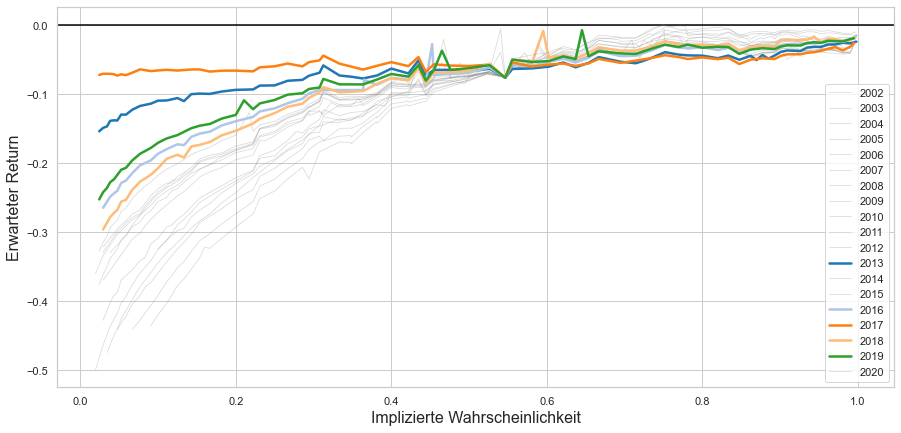

In [58]:
plt.figure(figsize=(15, 7))
plt.axhline(0, c="black")
for i,y in zip(Replication.seasons.unique(),res_bs.params[1:]):
    if i ==2013:
        Vergleich(i,y)
    elif (i>=2016) & (i<2020):
        Vergleich(i,y)
    else:
        Vergleich_Grau(i,y)
plt.xlabel("Implizierte Wahrscheinlichkeit", fontsize=16)
plt.ylabel("Erwarteter Return", fontsize=16)
plt.show()

In [60]:
# Extract the favorite player und outsider as seperate columns
favPlayer=[]
for i in range(Original.shape[0]):
    favPlayer.append(Original["implied_pFav"].iloc[i][0])

outPlayer=[]
for i in range(Original.shape[0]):
    outPlayer.append(Original["implied_pOut"].iloc[i][0])
Original["favPlayer"]=favPlayer    
Original["outPlayer"]=outPlayer

favPlayer=[]
for i in range(Replication.shape[0]):
    favPlayer.append(Replication["implied_pFav"].iloc[i][0])

outPlayer=[]
for i in range(Replication.shape[0]):
    outPlayer.append(Replication["implied_pOut"].iloc[i][0])
Replication["favPlayer"]=favPlayer    
Replication["outPlayer"]=outPlayer  

In [61]:
# Extract the favorite player odds und outsider odds as seperate columns
fav_p=[]
for i in range(Original.shape[0]):
    fav_p.append(Original["implied_pFav"].iloc[i][1])

out_p=[]
for i in range(Original.shape[0]):
    out_p.append(Original["implied_pOut"].iloc[i][1])
Original["fav_p"]=fav_p    
Original["out_p"]=out_p 

fav_p=[]
for i in range(Replication.shape[0]):
    fav_p.append(Replication["implied_pFav"].iloc[i][1])

out_p=[]
for i in range(Replication.shape[0]):
    out_p.append(Replication["implied_pOut"].iloc[i][1])
Replication["fav_p"]=fav_p    
Replication["out_p"]=out_p   

In [62]:
Original.to_csv("Original2.csv",index=False)
Replication.to_csv("Replication2.csv",index=False)